In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
import numpy as np
import folium
import geopandas as gpd
import folium
from folium.plugins import HeatMapWithTime
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import itertools
from folium.plugins import MarkerCluster
import re
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from matplotlib.animation import FuncAnimation
from scipy.stats import gaussian_kde
import time
from shapely.geometry import Point
import contextily as ctx
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

C:\Users\DELL\AppData\Local\Temp\ipykernel_48400\2706789814.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(leaves))


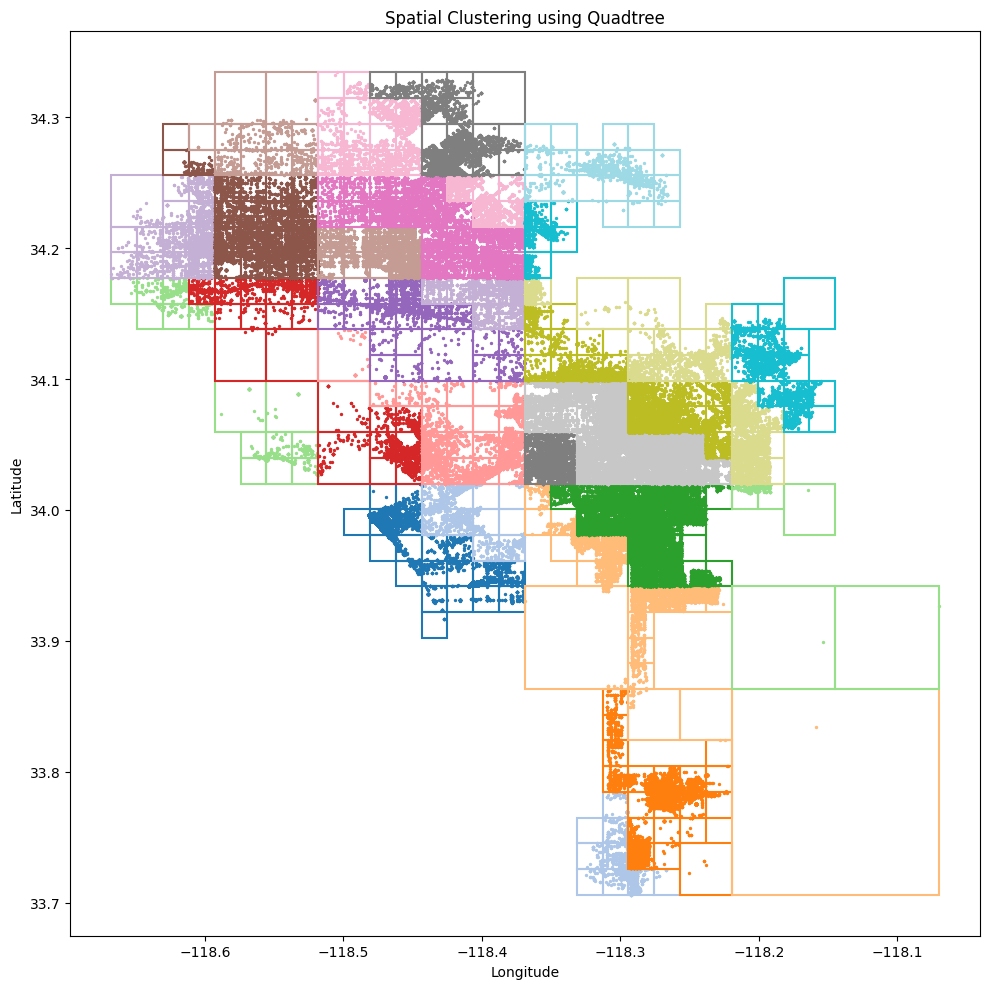

        LON      LAT  Hotspot
0 -118.2918  33.9771       83
1 -118.5884  34.1938      190
2 -118.4073  33.9939       22
3 -118.2847  33.9587       81
4 -118.3136  34.0918      295
Total unique hotspots: 380


In [5]:
# quadtree_spatial_clustering.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.cm as cm
import json

# ---- Load and preprocess data ----
df = pd.read_csv("Time_formatted_fixed_loc.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df[['Datetime', 'LAT', 'LON']].dropna()

# ---- QuadTree Class ----
class QuadTree:
    def __init__(self, x_min, x_max, y_min, y_max, points, max_points=100, depth=0, max_depth=5):
        self.bounds = (x_min, x_max, y_min, y_max)
        self.points = points
        self.children = []
        self.depth = depth
        self.max_points = max_points
        self.max_depth = max_depth
        self.is_leaf = False
        self.subdivide()

    def subdivide(self):
        if len(self.points) <= self.max_points or self.depth >= self.max_depth:
            self.is_leaf = True
            return

        x_min, x_max, y_min, y_max = self.bounds
        x_mid = (x_min + x_max) / 2
        y_mid = (y_min + y_max) / 2

        quadrants = [
            (x_min, x_mid, y_min, y_mid),
            (x_mid, x_max, y_min, y_mid),
            (x_min, x_mid, y_mid, y_max),
            (x_mid, x_max, y_mid, y_max),
        ]

        for bounds in quadrants:
            x0, x1, y0, y1 = bounds
            pts = [pt for pt in self.points if x0 <= pt[0] <= x1 and y0 <= pt[1] <= y1]
            if pts:
                child = QuadTree(x0, x1, y0, y1, pts, self.max_points, self.depth + 1, self.max_depth)
                self.children.append(child)

    def get_leaf_nodes(self):
        if self.is_leaf:
            return [self]
        leaves = []
        for child in self.children:
            leaves.extend(child.get_leaf_nodes())
        return leaves


points = list(zip(df['LON'], df['LAT']))
x_min, x_max = df['LON'].min(), df['LON'].max()
y_min, y_max = df['LAT'].min(), df['LAT'].max()

qt = QuadTree(x_min, x_max, y_min, y_max, points)

leaves = qt.get_leaf_nodes()
colors = cm.get_cmap('tab20', len(leaves))

point_to_cluster = {}
for idx, leaf in enumerate(leaves):
    for pt in leaf.points:
        point_to_cluster[pt] = idx

df['Hotspot'] = df.apply(lambda row: point_to_cluster.get((row['LON'], row['LAT']), -1), axis=1)

# ---- Visualization using matplotlib ----
fig, ax = plt.subplots(figsize=(10, 10))

for idx, leaf in enumerate(leaves):
    x_min, x_max, y_min, y_max = leaf.bounds
    rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                     fill=False, edgecolor=colors(idx), linewidth=1.5)
    ax.add_patch(rect)

    if leaf.points:
        xs, ys = zip(*leaf.points)
        ax.scatter(xs, ys, s=2, color=colors(idx), label=f'Cluster {idx}' if idx < 10 else None)

ax.set_title("Spatial Clustering using Quadtree")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

# ---- Optional: Check results ----
print(df[['LON', 'LAT', 'Hotspot']].head())
print("Total unique hotspots:", df['Hotspot'].nunique())


In [4]:
df['Hotspot'].value_counts()

Hotspot
303    13859
300    11291
305     9236
83      8385
299     7274
       ...  
26         2
59         1
96         1
99         1
95         1
Name: count, Length: 380, dtype: int64

In [6]:
df['Date'] = df['Datetime'].dt.to_period('W').apply(lambda r: r.start_time)

In [7]:
time_series = df.groupby(['Date', 'Hotspot']).size().reset_index(name='CrimeCount')
ts_pivot = time_series.pivot(index='Date', columns='Hotspot', values='CrimeCount').fillna(0)
ts_pivot = ts_pivot.sort_index()
ts_pivot.index = pd.DatetimeIndex(ts_pivot.index, freq='W-MON')  

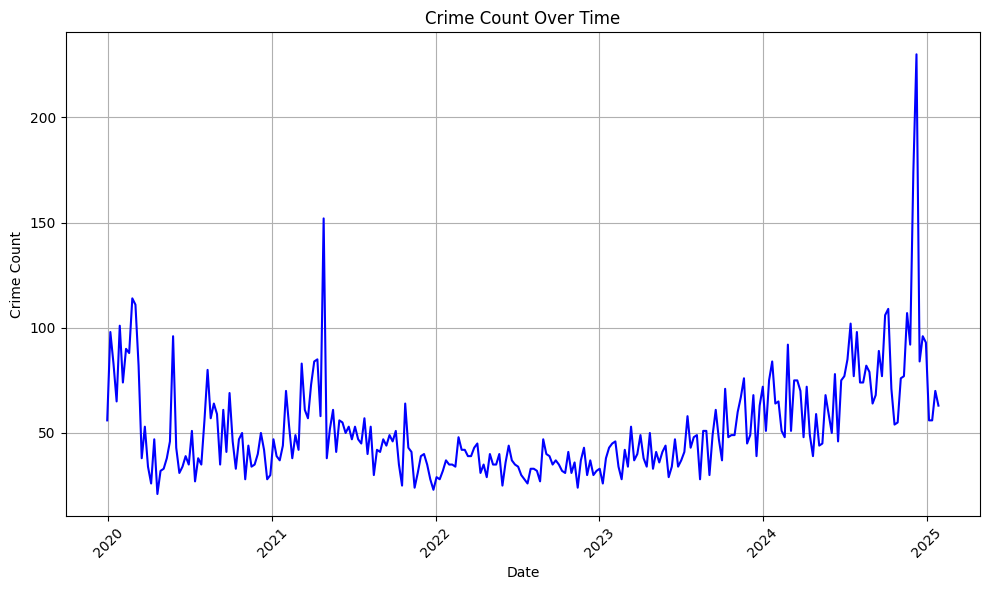

In [13]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(ts_pivot[0].index, ts_pivot[303], label='Crime Count', color='b')
plt.title('Crime Count Over Time')
plt.xlabel('Date')
plt.ylabel('Crime Count')    
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

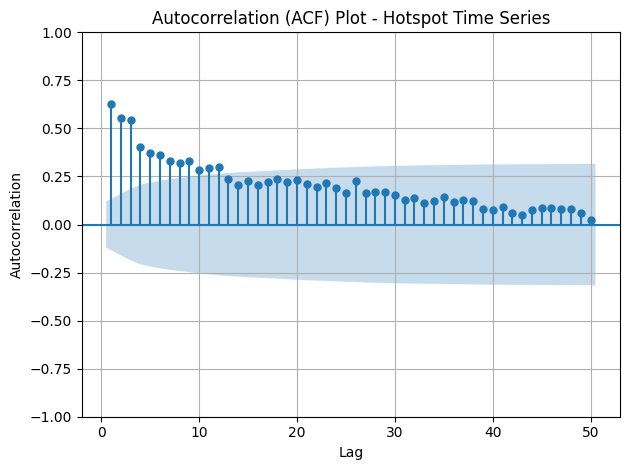

In [17]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

hotspot_series = ts_pivot[303].values

plt.figure(figsize=(10, 5))
plot_acf(hotspot_series, lags=50, zero=False)
plt.title("Autocorrelation (ACF) Plot - Hotspot Time Series")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima as pm

warnings.filterwarnings("ignore")
hotspot_series = ts_pivot[303].values
dates = ts_pivot.index

# === Train-Test Split (80/20) ===
split_idx = int(len(hotspot_series) * 0.8)
train_data = hotspot_series[:split_idx]
test_data = hotspot_series[split_idx:]
test_dates = dates[split_idx:]

# === 1. ADF Test ===
print("== ADF Stationarity Test ==")
adf_result = adfuller(train_data)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("=> Stationary" if adf_result[1] < 0.05 else "=> Non-Stationary")


== ADF Stationarity Test ==
ADF Statistic: -4.0880
p-value: 0.0010
=> Stationary


In [19]:
# Use the raw values directly for training and testing

hotspot_series = ts_pivot[303].values  # Use the original values (no scaling)

# --- Train/test split (80/20) on the raw time series ---
split_idx = int(len(hotspot_series) * 0.8)
y_train = hotspot_series[:split_idx]
y_test = hotspot_series[split_idx:]

# Print some of the data values for verification
print("y_train (original data):", y_train[:5])  # Print the first 5 values of y_train
print("y_test (original data):", y_test[:5])  # Print the first 5 values of y_test

y_train (original data): [ 56.  98.  83.  65. 101.]
y_test (original data): [84. 64. 65. 51. 48.]


In [21]:
import numpy as np
import warnings
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# --- Preprocessing ---
hotspot_series = ts_pivot[303].values.reshape(-1, 1)

# Normalize the data to scale it between 0 and 1
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# --- Train/Test split (80/20) ---
split_idx = int(len(hotspot_scaled) * 0.8)
train_scaled = hotspot_scaled[:split_idx].flatten()
test_scaled = hotspot_scaled[split_idx:].flatten()

# --- Inverse transform helper ---
def inverse_transform(y_scaled):
    return scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

warnings.filterwarnings('ignore')

# --- Fit AR models with different lags and select best ---
best_ar_rmse = float('inf')
best_ar_lag = None

for lag in range(1, 40):  # test lags from 1 to 40
    try:
        model_ar = AutoReg(train_scaled, lags=lag, old_names=False).fit()
        pred_scaled = model_ar.predict(start=len(train_scaled), end=len(train_scaled) + len(test_scaled) - 1)
        pred = inverse_transform(pred_scaled)
        actual = inverse_transform(test_scaled)

        rmse = mean_squared_error(actual, pred, squared=False)
        if rmse < best_ar_rmse:
            best_ar_rmse = rmse
            best_ar_lag = lag
            best_ar_pred = pred
            best_ar_actual = actual
    except:
        continue

# --- Output ---
print(f"Best AR Lag: {best_ar_lag}")
print(f"AR RMSE: {best_ar_rmse:.2f}")
print(f"AR MAPE: {mean_absolute_percentage_error(best_ar_actual, best_ar_pred)*100:.2f}%")


Best AR Lag: 31
AR RMSE: 40.44
AR MAPE: 29.64%


In [36]:
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

hotspot_series = ts_pivot[303].values.flatten()

# --- Train/Test split (80/20) ---
split_idx = int(len(hotspot_series) * 0.8)
train = hotspot_series[:split_idx]
test = hotspot_series[split_idx:]

# Suppress warnings
warnings.filterwarnings('ignore')

# Define parameter ranges
p = d = q = range(0, 2)
P = D = Q = range(0, 3)
s = 7  # Weekly seasonality

best_rmse = float('inf')
best_order = None
best_seasonal_order = None

# --- SARIMA Grid Search ---
for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q):
        try:
            model = SARIMAX(
                train,
                order=order,
                seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)

            pred = model.forecast(steps=len(test))

            rmse = mean_squared_error(test, pred, squared=False)
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
                best_seasonal_order = seasonal_order
                best_pred = pred
                best_actual = test
        except:
            continue

# --- Output Best SARIMA Model ---
print(f"Best SARIMA Order: {best_order}, Seasonal: {best_seasonal_order} x {s}")
print(f"SARIMA RMSE: {best_rmse:.2f}")
print(f"SARIMA MAPE: {mean_absolute_percentage_error(best_actual, best_pred)*100:.2f}%")


Best SARIMA Order: (1, 1, 1), Seasonal: (2, 2, 2) x 7
SARIMA RMSE: 28.65
SARIMA MAPE: 27.65%


In [25]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# --- Prepare lag features ---
def create_lag_features(series, n_lags=36):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Use raw values
hotspot_series = ts_pivot[303].values.flatten()

# Create lagged features
n_lags = 12  # Use previous 12 time steps to predict next
X, y = create_lag_features(hotspot_series, n_lags=n_lags)

# Train/Test Split (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- XGBoost Regressor ---
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Predictions ---
y_pred = model.predict(X_test)

# --- Evaluation ---
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost MAPE: {mape:.2f}%")

XGBoost RMSE: 36.52
XGBoost MAPE: 37.91%



For lag = 1
Test RMSE: 30.0337
MAPE: 25.63%

For lag = 2
Test RMSE: 29.7755
MAPE: 25.37%

For lag = 3
Test RMSE: 29.1142
MAPE: 25.03%

For lag = 4
Test RMSE: 29.3109
MAPE: 25.30%

For lag = 6
Test RMSE: 29.0689
MAPE: 25.03%

For lag = 9
Test RMSE: 28.6178
MAPE: 24.41%

For lag = 12
Test RMSE: 29.9103
MAPE: 24.84%

For lag = 16
Test RMSE: 32.3742
MAPE: 26.93%

For lag = 24
Test RMSE: 32.2098
MAPE: 26.89%

For lag = 30
Test RMSE: 31.7789
MAPE: 26.14%

For lag = 40
Test RMSE: 31.3777
MAPE: 26.22%

For lag = 50
Test RMSE: 32.5280
MAPE: 27.03%


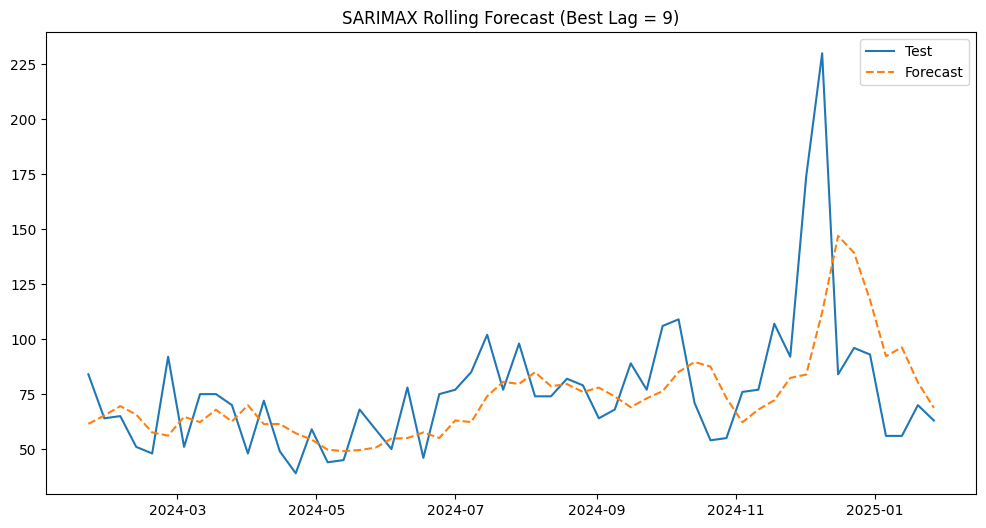

In [26]:
import torch.nn as nn
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

series = ts_pivot[303].astype(float).dropna()  # Example hotspot 0

lag_arr = [1, 2, 3, 4, 6, 9, 12, 16, 24, 30, 40, 50]

best_rmse = float('inf')
best_result = {}

for lag in lag_arr:
    train_size = int(len(series) * 0.8)
    train, test = series.iloc[:train_size], series.iloc[train_size:]

    # Ensure correct data types and index
    train = pd.Series(train.values, index=train.index, dtype='float')
    test = pd.Series(test.values, index=test.index, dtype='float')

    model = SARIMAX(
        train,
        order=(lag, 0, 0),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    # Append test to Kalman filter
    res_ext = res.append(test)

    # One-step-ahead prediction
    pred = res_ext.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
    y_pred = pred.predicted_mean

    if len(y_pred) == len(test):
        # Evaluate
        rmse = np.sqrt(mean_squared_error(test, y_pred))
        mape = mean_absolute_percentage_error(test, y_pred)
        print(f"\nFor lag = {lag}")
        print(f"Test RMSE: {rmse:.4f}")
        print(f"MAPE: {mape * 100:.2f}%")

        if rmse < best_rmse:
            best_rmse = rmse
            best_result = {
                "lag": lag,
                "test": test,
                "y_pred": y_pred
            }

# Optional: plot best forecast
if best_result:
    plt.figure(figsize=(12, 6))
    plt.plot(best_result["test"].index, best_result["test"], label="Test")
    plt.plot(best_result["y_pred"].index, best_result["y_pred"], label="Forecast", linestyle="--")
    plt.legend()
    plt.title(f"SARIMAX Rolling Forecast (Best Lag = {best_result['lag']})")
    plt.show()


Epoch 1, Loss: 0.1500
Epoch 2, Loss: 0.1354
Epoch 3, Loss: 0.1290
Epoch 4, Loss: 0.1351
Epoch 5, Loss: 0.1364
Epoch 6, Loss: 0.1356
Epoch 7, Loss: 0.1346
Epoch 8, Loss: 0.1344
Epoch 9, Loss: 0.1339
Epoch 10, Loss: 0.1342
Epoch 11, Loss: 0.1347
Epoch 12, Loss: 0.1341
Epoch 13, Loss: 0.1338
Epoch 14, Loss: 0.1328
Epoch 15, Loss: 0.1223
Epoch 16, Loss: 0.1217
Epoch 17, Loss: 0.1215
Epoch 18, Loss: 0.1097
Epoch 19, Loss: 0.1122
Epoch 20, Loss: 0.1083
Epoch 21, Loss: 0.1068
Epoch 22, Loss: 0.1050
Epoch 23, Loss: 0.1064
Epoch 24, Loss: 0.1024
Epoch 25, Loss: 0.1008
Epoch 26, Loss: 0.1019
Epoch 27, Loss: 0.1031
Epoch 28, Loss: 0.0974
Epoch 29, Loss: 0.0967
Epoch 30, Loss: 0.0993
Epoch 31, Loss: 0.0970
Epoch 32, Loss: 0.0967
Epoch 33, Loss: 0.1037
Epoch 34, Loss: 0.1069
Epoch 35, Loss: 0.1017
Epoch 36, Loss: 0.1017
Epoch 37, Loss: 0.1007
Epoch 38, Loss: 0.0984
Epoch 39, Loss: 0.0961
Epoch 40, Loss: 0.0987
Epoch 41, Loss: 0.1039
Epoch 42, Loss: 0.0985
Epoch 43, Loss: 0.1073
Epoch 44, Loss: 0.11

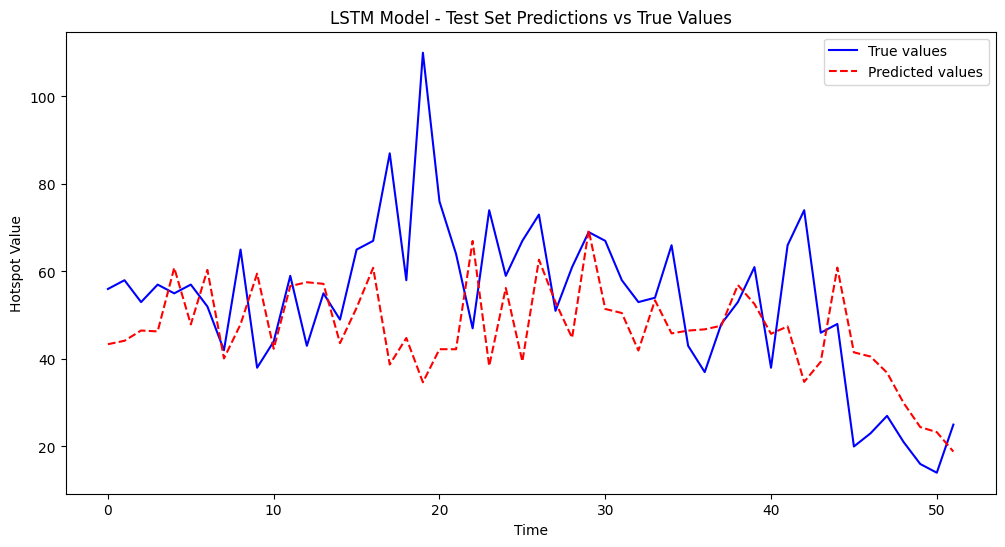

Test RMSE: 19.0335
Test MAPE: 26.82%


In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Assuming ts_pivot is a pandas DataFrame with time series data

hotspot_series = ts_pivot[300].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# Prepare sequences (7 weeks in → 1 week out)
def create_sequences(data, seq_len=7):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

# Create sequences for input features and labels
X, y = create_sequences(hotspot_scaled)

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert the data to tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# Create DataLoader for the training set
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=4, batch_first=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.relu(out[:, -1, :])
        return self.fc(out)

# Initialize model, loss function, and optimizer
model = LSTMModel()
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
model.train()
for epoch in range(200):
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# After training, evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = loss_fn(y_pred, y_test_tensor)
    print(f"Test Loss (L1): {test_loss.item():.4f}")

# Inverse transform to get the predictions in the original scale
y_test_original = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

# Plot the predictions vs true values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="True values", color='blue')
plt.plot(y_pred_original, label="Predicted values", color='red', linestyle='--')
plt.title("LSTM Model - Test Set Predictions vs True Values")
plt.xlabel("Time")
plt.ylabel("Hotspot Value")
plt.legend()
plt.show()

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAPE: {mape * 100:.2f}%")

In [27]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# --- Prepare lag features ---
def create_lag_features(series, n_lags=36):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Use raw values
hotspot_series = ts_pivot[303].values.flatten()

# Create lagged features
n_lags = 12  # Use previous 12 time steps to predict next
X, y = create_lag_features(hotspot_series, n_lags=n_lags)

# Train/Test Split (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- XGBoost Regressor ---
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Predictions ---
y_pred = model.predict(X_test)

# --- Evaluation ---
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost MAPE: {mape:.2f}%")

XGBoost RMSE: 36.52
XGBoost MAPE: 37.91%


### Second Largest Cluster

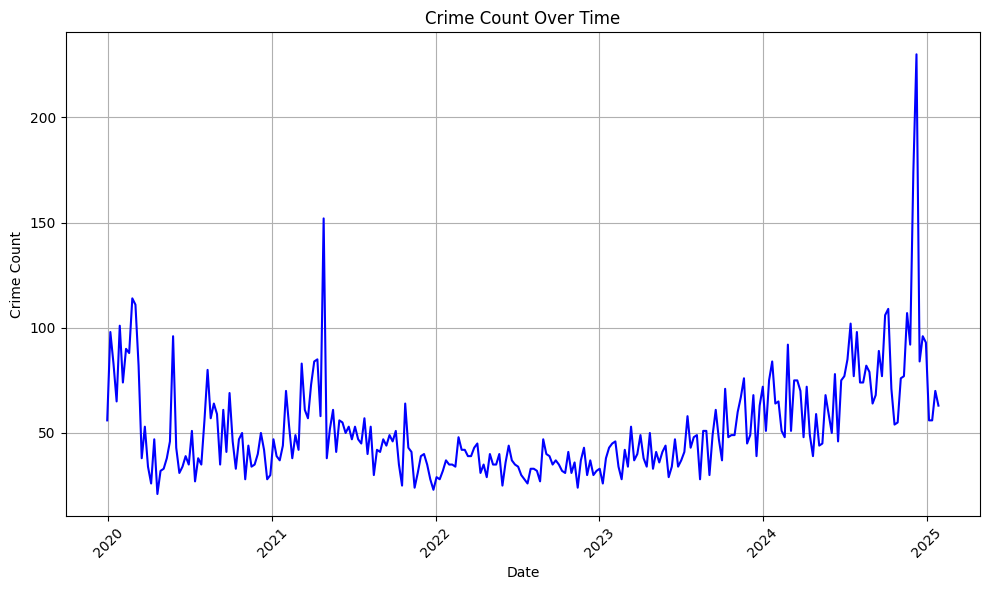

In [29]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(ts_pivot[0].index, ts_pivot[300], label='Crime Count', color='b')
plt.title('Crime Count Over Time')
plt.xlabel('Date')
plt.ylabel('Crime Count')    
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

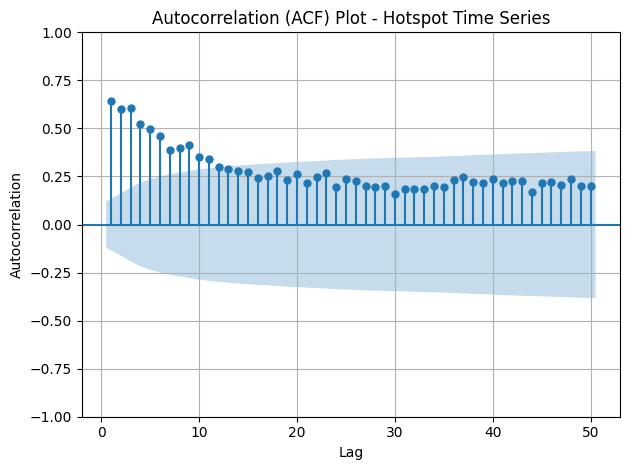

In [30]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

hotspot_series = ts_pivot[300].values

plt.figure(figsize=(10, 5))
plot_acf(hotspot_series, lags=50, zero=False)
plt.title("Autocorrelation (ACF) Plot - Hotspot Time Series")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima as pm

# --- Suppress warnings and logs ---
warnings.filterwarnings("ignore")
hotspot_series = ts_pivot[300].values
dates = ts_pivot.index

# === Train-Test Split (80/10) ===
split_idx = int(len(hotspot_series) * 0.8)
train_data = hotspot_series[:split_idx]
test_data = hotspot_series[split_idx:]
test_dates = dates[split_idx:]

# === 1. ADF Test ===
print("== ADF Stationarity Test ==")
adf_result = adfuller(train_data)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("=> Stationary" if adf_result[1] < 0.05 else "=> Non-Stationary")


== ADF Stationarity Test ==
ADF Statistic: -3.0436
p-value: 0.0310
=> Stationary


In [32]:

hotspot_series = ts_pivot[300].values  # Use the original values (no scaling)

# --- Train/test split (80/20) on the raw time series ---
split_idx = int(len(hotspot_series) * 0.8)
y_train = hotspot_series[:split_idx]
y_test = hotspot_series[split_idx:]

# Now, y_train and y_test contain the raw data without any scaling.
# Print some of the data values for verification
print("y_train (original data):", y_train[:5])  # Print the first 5 values of y_train
print("y_test (original data):", y_test[:5])  # Print the first 5 values of y_test

y_train (original data): [44. 36. 41. 43. 58.]
y_test (original data): [52. 68. 56. 58. 53.]


In [34]:
import numpy as np
import warnings
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# --- Preprocessing ---
hotspot_series = ts_pivot[300].values.reshape(-1, 1)

# Normalize the data to scale it between 0 and 1
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# --- Train/Test split (80/20) ---
split_idx = int(len(hotspot_scaled) * 0.8)
train_scaled = hotspot_scaled[:split_idx].flatten()
test_scaled = hotspot_scaled[split_idx:].flatten()

# --- Inverse transform helper ---
def inverse_transform(y_scaled):
    return scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

# Suppress all warnings
warnings.filterwarnings('ignore')

# --- Fit AR models with different lags and select best ---
best_ar_rmse = float('inf')
best_ar_lag = None

for lag in range(1, 40):  # test lags from 1 to 40
    try:
        model_ar = AutoReg(train_scaled, lags=lag, old_names=False).fit()
        pred_scaled = model_ar.predict(start=len(train_scaled), end=len(train_scaled) + len(test_scaled) - 1)
        pred = inverse_transform(pred_scaled)
        actual = inverse_transform(test_scaled)

        rmse = mean_squared_error(actual, pred, squared=False)
        if rmse < best_ar_rmse:
            best_ar_rmse = rmse
            best_ar_lag = lag
            best_ar_pred = pred
            best_ar_actual = actual
    except:
        continue

# --- Output ---
print(f"Best AR Lag: {best_ar_lag}")
print(f"AR RMSE: {best_ar_rmse:.2f}")
print(f"AR MAPE: {mean_absolute_percentage_error(best_ar_actual, best_ar_pred)*100:.2f}%")


Best AR Lag: 23
AR RMSE: 17.34
AR MAPE: 35.08%


In [37]:
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

hotspot_series = ts_pivot[300].values.flatten()

# --- Train/Test split (80/20) ---
split_idx = int(len(hotspot_series) * 0.8)
train = hotspot_series[:split_idx]
test = hotspot_series[split_idx:]

# Suppress warnings
warnings.filterwarnings('ignore')

# Define parameter ranges
p = d = q = range(0, 2)
P = D = Q = range(0, 3)
s = 7  # Weekly seasonality

best_rmse = float('inf')
best_order = None
best_seasonal_order = None

# --- SARIMA Grid Search ---
for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q):
        try:
            model = SARIMAX(
                train,
                order=order,
                seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)

            pred = model.forecast(steps=len(test))

            rmse = mean_squared_error(test, pred, squared=False)
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
                best_seasonal_order = seasonal_order
                best_pred = pred
                best_actual = test
        except:
            continue

# --- Output Best SARIMA Model ---
print(f"Best SARIMA Order: {best_order}, Seasonal: {best_seasonal_order} x {s}")
print(f"SARIMA RMSE: {best_rmse:.2f}")
print(f"SARIMA MAPE: {mean_absolute_percentage_error(best_actual, best_pred)*100:.2f}%")


Best SARIMA Order: (1, 0, 1), Seasonal: (0, 0, 0) x 7
SARIMA RMSE: 16.92
SARIMA MAPE: 35.58%


In [38]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# --- Prepare lag features ---
def create_lag_features(series, n_lags=36):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Use raw values
hotspot_series = ts_pivot[300].values.flatten()

# Create lagged features
n_lags = 12  # Use previous 12 time steps to predict next
X, y = create_lag_features(hotspot_series, n_lags=n_lags)

# Train/Test Split (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- XGBoost Regressor ---
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Predictions ---
y_pred = model.predict(X_test)

# --- Evaluation ---
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost MAPE: {mape:.2f}%")

XGBoost RMSE: 16.42
XGBoost MAPE: 31.65%



For lag = 1
Test RMSE: 16.2788
MAPE: 24.84%

For lag = 2
Test RMSE: 13.9432
MAPE: 23.15%

For lag = 3
Test RMSE: 14.0021
MAPE: 23.47%

For lag = 4
Test RMSE: 13.8927
MAPE: 23.58%

For lag = 6
Test RMSE: 14.1381
MAPE: 24.60%

For lag = 9
Test RMSE: 13.9213
MAPE: 24.39%

For lag = 12
Test RMSE: 13.9739
MAPE: 24.63%

For lag = 16
Test RMSE: 14.3913
MAPE: 26.52%

For lag = 24
Test RMSE: 14.6736
MAPE: 27.97%

For lag = 30
Test RMSE: 15.6848
MAPE: 29.02%

For lag = 40
Test RMSE: 17.0046
MAPE: 31.09%

For lag = 50
Test RMSE: 16.8497
MAPE: 30.61%


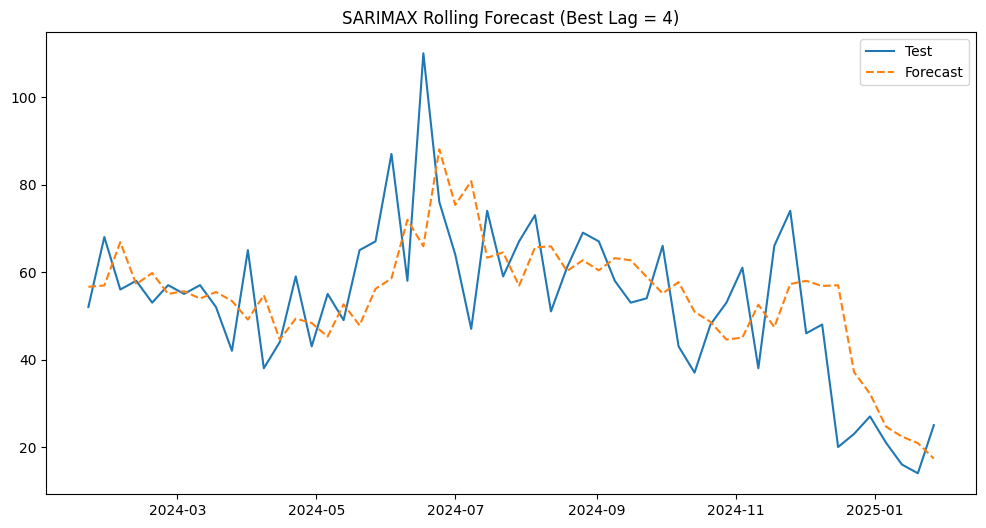

In [7]:
import torch.nn as nn
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

series = ts_pivot[300].astype(float).dropna()  # Example hotspot 0

lag_arr = [1, 2, 3, 4, 6, 9, 12, 16, 24, 30, 40, 50]

best_rmse = float('inf')
best_result = {}

for lag in lag_arr:
    train_size = int(len(series) * 0.8)
    train, test = series.iloc[:train_size], series.iloc[train_size:]

    # Ensure correct data types and index
    train = pd.Series(train.values, index=train.index, dtype='float')
    test = pd.Series(test.values, index=test.index, dtype='float')

    model = SARIMAX(
        train,
        order=(lag, 0, 0),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    # Append test to Kalman filter
    res_ext = res.append(test)

    # One-step-ahead prediction
    pred = res_ext.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
    y_pred = pred.predicted_mean

    if len(y_pred) == len(test):
        # Evaluate
        rmse = np.sqrt(mean_squared_error(test, y_pred))
        mape = mean_absolute_percentage_error(test, y_pred)
        print(f"\nFor lag = {lag}")
        print(f"Test RMSE: {rmse:.4f}")
        print(f"MAPE: {mape * 100:.2f}%")

        if rmse < best_rmse:
            best_rmse = rmse
            best_result = {
                "lag": lag,
                "test": test,
                "y_pred": y_pred
            }

# Optional: plot best forecast
if best_result:
    plt.figure(figsize=(12, 6))
    plt.plot(best_result["test"].index, best_result["test"], label="Test")
    plt.plot(best_result["y_pred"].index, best_result["y_pred"], label="Forecast", linestyle="--")
    plt.legend()
    plt.title(f"SARIMAX Rolling Forecast (Best Lag = {best_result['lag']})")
    plt.show()


Epoch 1, Loss: 0.0631
Epoch 2, Loss: 0.0553
Epoch 3, Loss: 0.0547
Epoch 4, Loss: 0.0549
Epoch 5, Loss: 0.0560
Epoch 6, Loss: 0.0547
Epoch 7, Loss: 0.0550
Epoch 8, Loss: 0.0547
Epoch 9, Loss: 0.0545
Epoch 10, Loss: 0.0569
Epoch 11, Loss: 0.0548
Epoch 12, Loss: 0.0545
Epoch 13, Loss: 0.0546
Epoch 14, Loss: 0.0554
Epoch 15, Loss: 0.0549
Epoch 16, Loss: 0.0548
Epoch 17, Loss: 0.0550
Epoch 18, Loss: 0.0555
Epoch 19, Loss: 0.0546
Epoch 20, Loss: 0.0547
Epoch 21, Loss: 0.0554
Epoch 22, Loss: 0.0547
Epoch 23, Loss: 0.0543
Epoch 24, Loss: 0.0543
Epoch 25, Loss: 0.0553
Epoch 26, Loss: 0.0546
Epoch 27, Loss: 0.0546
Epoch 28, Loss: 0.0545
Epoch 29, Loss: 0.0532
Epoch 30, Loss: 0.0549
Epoch 31, Loss: 0.0551
Epoch 32, Loss: 0.0533
Epoch 33, Loss: 0.0546
Epoch 34, Loss: 0.0551
Epoch 35, Loss: 0.0550
Epoch 36, Loss: 0.0550
Epoch 37, Loss: 0.0546
Epoch 38, Loss: 0.0545
Epoch 39, Loss: 0.0506
Epoch 40, Loss: 0.0558
Epoch 41, Loss: 0.0546
Epoch 42, Loss: 0.0545
Epoch 43, Loss: 0.0548
Epoch 44, Loss: 0.05

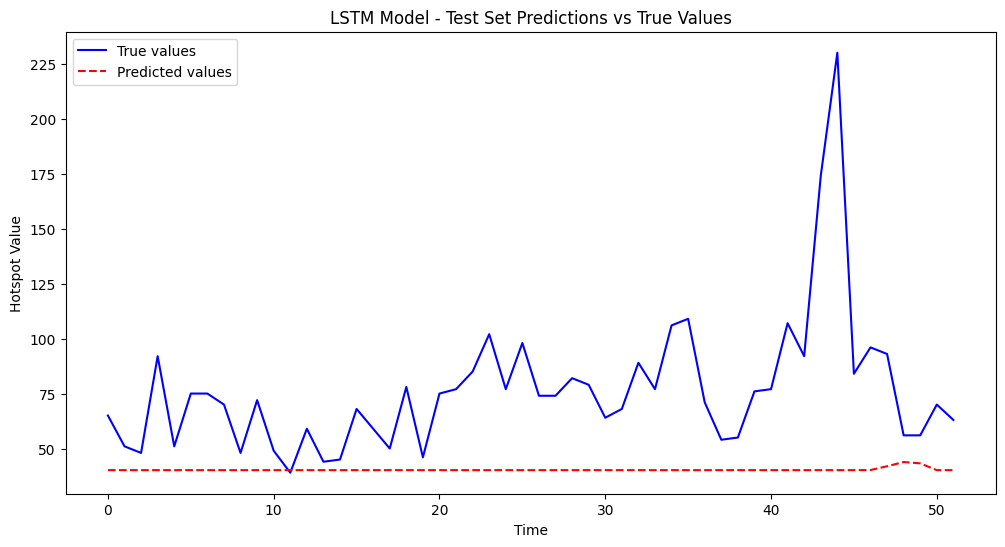

Test RMSE: 47.7206
Test MAPE: 41.25%


In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Assuming ts_pivot is a pandas DataFrame with time series data
hotspot_series = ts_pivot[303].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# Prepare sequences (7 weeks in → 1 week out)
def create_sequences(data, seq_len=7):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

# Create sequences for input features and labels
X, y = create_sequences(hotspot_scaled)

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert the data to tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# Create DataLoader for the training set
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=4, batch_first=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.relu(out[:, -1, :])
        return self.fc(out)

# Initialize model, loss function, and optimizer
model = LSTMModel()
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
model.train()
for epoch in range(200):
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# After training, evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = loss_fn(y_pred, y_test_tensor)
    print(f"Test Loss (L1): {test_loss.item():.4f}")

# Inverse transform to get the predictions in the original scale
y_test_original = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

# Plot the predictions vs true values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="True values", color='blue')
plt.plot(y_pred_original, label="Predicted values", color='red', linestyle='--')
plt.title("LSTM Model - Test Set Predictions vs True Values")
plt.xlabel("Time")
plt.ylabel("Hotspot Value")
plt.legend()
plt.show()

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAPE: {mape * 100:.2f}%")
